In [26]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import lightgbm as lgbm

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import  ensemble

In [27]:
#%cd ./network_sniff/
#%ls

# 0) Create reporting 

In [28]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           #verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    print("F1: ", round(score["test_f1"].mean(), precision))
    print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [29]:
df_mining = pd.read_csv(os.getcwd()+'/network_sniff/traffic_minage_1811_15.csv', index_col= 0)
df_not_mining = pd.read_csv(os.getcwd()+'/network_sniff/2911_traffic_calme.csv', index_col= 0)

In [30]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining
Moreover we add the direction of the package

In [31]:
df_mining['miner'] = True
df_mining['outbound'] = df_mining['Source'].apply(lambda x : x == '10.29.231.206') #change ip of miner
df_not_mining['miner'] = False
df_not_mining['outbound'] = df_not_mining['Source'].apply(lambda x : x == '10.29.229.98')

Compute time difference between two packages

In [32]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

Compute time and packet size rolling average and std

In [33]:
window = 4

In [34]:
# delta
# Rolling average
df_mining['ra_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['ra_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['rstd_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()

# Lenght
# Rolling average
df_mining['ra_lenght'] = df_mining.Length.rolling(window=window).mean()
df_not_mining['ra_lenght'] = df_not_mining.Length.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_lenght'] = df_mining.Length.rolling(window=window).std()
df_not_mining['rstd_lenght'] = df_not_mining.Length.diff().rolling(window=window).std()


In [35]:
df_ML = pd.concat([df_mining, df_not_mining], ignore_index=True)
df_ML.reset_index(inplace = True, drop = True)
df_ML.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)


In [36]:
df_ML.describe()

,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
count,41272.000000,4.127000e+04,4.126300e+04,4.126300e+04,41265.000000,41265.000000
mean,753.771613,3.151798e-02,1.453039e-03,1.453039e-03,0.168939,1332.260381
std,1059.517408,6.948798e-01,2.461157e-01,2.461157e-01,282.003832,1201.291351
min,42.000000,-6.600010e-08,-2.729894e+01,-2.729894e+01,-1134.000000,0.000000
25%,66.000000,1.103925e-05,-5.942175e-05,-5.942175e-05,-20.250000,175.200837
50%,105.000000,1.887860e-04,-4.725001e-08,-4.725001e-08,0.000000,1143.095213
75%,1466.000000,4.567025e-04,5.934062e-05,5.934062e-05,21.750000,2364.574098
max,6806.000000,1.092041e+02,2.730102e+01,2.730102e+01,1637.750000,5287.348422


In [37]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'miner', 'outbound', 'delta', 'ra_delta', 'rstd_delta',
       'ra_lenght', 'rstd_lenght'],
      dtype='object')

In [38]:
df_ML.groupby('miner').mean()

,Length,outbound,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
miner,,,,,,,
False,755.204045,0.468117,0.030102,-4.894163e-08,-4.894163e-08,-0.005330,1334.872385
True,84.024691,0.543210,0.753654,7.402318e-01,7.402318e-01,86.472222,30.853181


array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'delta'}>],
       [<AxesSubplot: title={'center': 'ra_delta'}>,
        <AxesSubplot: title={'center': 'rstd_delta'}>],
       [<AxesSubplot: title={'center': 'ra_lenght'}>,
        <AxesSubplot: title={'center': 'rstd_lenght'}>]], dtype=object)

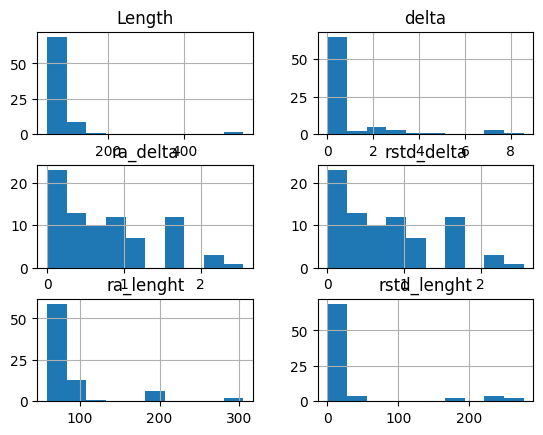

In [39]:
df_ML.loc[df_ML['miner'] == True].hist()

array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'delta'}>],
       [<AxesSubplot: title={'center': 'ra_delta'}>,
        <AxesSubplot: title={'center': 'rstd_delta'}>],
       [<AxesSubplot: title={'center': 'ra_lenght'}>,
        <AxesSubplot: title={'center': 'rstd_lenght'}>]], dtype=object)

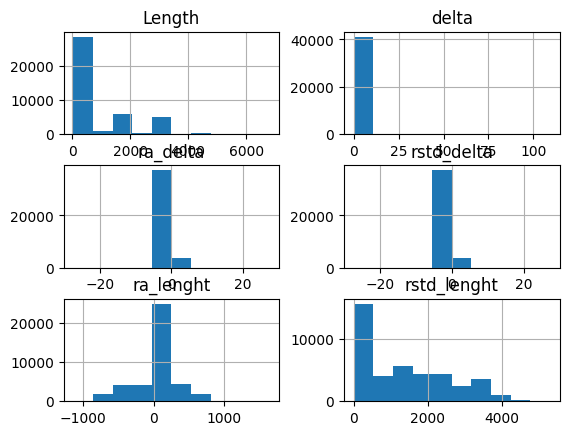

In [40]:
df_ML.loc[df_ML['miner'] == False].hist()

In [41]:
y = df_ML['miner']
x = df_ML.drop('miner', axis = 1)

In [42]:
y.describe

<bound method NDFrame.describe of 4         True
5         True
6         True
7         True
8         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41263, dtype: bool>

In [43]:
y.value_counts()

False    41182
True        81
Name: miner, dtype: int64

# ML Algorithm

In [44]:
#Setting model
model = svm.SVC(kernel="rbf", gamma="scale", class_weight='balanced')

In [45]:
model_cv_rapport(model, "Non tuned SVC", x, y)

Non tuned SVC --------------------------------------
Precision:  0.65095942
Recall:  0.9625
F1:  0.75489397
ROC:  0.99716338
Accuracy:  0.99849741


In [46]:
# Neuoral Network Model
model_nn = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu', solver='sgd', random_state=1, max_iter=20, batch_size='auto', verbose=True)
model_cv_rapport(model_nn, "Neuoral Network Classfication", x, y)

Iteration 1, loss = 0.26226299
Iteration 1, loss = 0.26267669
Iteration 1, loss = 0.26684057
Iteration 1, loss = 0.26406712
Iteration 1, loss = 0.26313106
Iteration 2, loss = 0.06429925
Iteration 2, loss = 0.06442681
Iteration 2, loss = 0.07164566
Iteration 2, loss = 0.06493430
Iteration 2, loss = 0.06542921
Iteration 3, loss = 0.03619198
Iteration 3, loss = 0.03621746
Iteration 3, loss = 0.03658458
Iteration 3, loss = 0.04287917
Iteration 3, loss = 0.03659182
Iteration 4, loss = 0.02720586
Iteration 4, loss = 0.02725899
Iteration 4, loss = 0.03245116
Iteration 4, loss = 0.02754842
Iteration 4, loss = 0.02742078
Iteration 5, loss = 0.02302559
Iteration 5, loss = 0.02314975
Iteration 5, loss = 0.02650884
Iteration 5, loss = 0.02336771
Iteration 5, loss = 0.02317388
Iteration 6, loss = 0.02061112
Iteration 6, loss = 0.02083562
Iteration 6, loss = 0.02224143
Iteration 6, loss = 0.02098445
Iteration 6, loss = 0.02075580
Iteration 7, loss = 0.01899065
Iteration 7, loss = 0.01932829
Iteratio

/home/augustin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/augustin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter

Iteration 20, loss = 0.01140938
Neuoral Network Classfication --------------------------------------
Precision:  0.2
Recall:  0.0625
F1:  0.0952381
ROC:  0.86982084
Accuracy:  0.99815817


/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# Loigistic Regression
model_lr=SGDClassifier(max_iter=100, tol=1e-3,eta0=0.02,loss='log',verbose=2)
model_cv_rapport(model_lr, "Neuoral Network Classfication", x, y)

/home/augustin/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 25.21, NNZs: 7, Bias: -51.516976, T: 33010, Avg. loss: 0.115477
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 12.00, NNZs: 7, Bias: -19.266827, T: 33010, Avg. loss: 0.039183
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 51.71, NNZs: 7, Bias: -25.574904, T: 33011, Avg. loss: 0.174040
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 24.08, NNZs: 7, Bias: -42.040128, T: 33011, Avg. loss: 0.267193
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 9.13, NNZs: 7, Bias: -16.093342, T: 66020, Avg. loss: 0.009843
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 20.70, NNZs: 7, Bias: -43.192380, T: 66020, Avg. loss: 0.031921
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 26.25, NNZs: 7, Bias: -19.851532, T: 66022, Avg. loss: 0.029718
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 15.77, NNZs: 7, Bias: -38.298064, T: 66022, Avg. loss: 0.080862
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 24.24, NNZs: 7, Bias: -

/home/augustin/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


-- Epoch 1
Norm: 29.62, NNZs: 7, Bias: -74.227383, T: 33010, Avg. loss: 0.718454
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 32.41, NNZs: 7, Bias: -65.798994, T: 66020, Avg. loss: 0.118177
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 25.36, NNZs: 7, Bias: -61.975229, T: 99030, Avg. loss: 0.034796
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 23.16, NNZs: 7, Bias: -58.846394, T: 132040, Avg. loss: 0.037964
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 23.84, NNZs: 7, Bias: -55.806762, T: 165050, Avg. loss: 0.058174
Total training time: 0.03 seconds.
-- Epoch 6
Norm: 22.52, NNZs: 7, Bias: -53.724064, T: 198060, Avg. loss: 0.030263
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 22.24, NNZs: 7, Bias: -51.981023, T: 231070, Avg. loss: 0.043604
Total training time: 0.03 seconds.
-- Epoch 8
Norm: 22.36, NNZs: 7, Bias: -50.459861, T: 264080, Avg. loss: 0.030881
Total training time: 0.04 seconds.
-- Epoch 9
Norm: 21.53, NNZs: 7, Bias: -48.871333, T: 297090, Avg. 